<a href="https://colab.research.google.com/github/kinqsradio/COS10004-Computer-System/blob/main/Data_Processing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Aug 23 07:38:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q pandas-datareader
!pip install -q yfinance

In [3]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')

# Set the working directory for the tasks
SKELETON_DIR = '/content/drive/MyDrive/stock-prediction/Test'
os.chdir(SKELETON_DIR)

Mounted at /content/drive/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.utils import plot_model


In [42]:
start='2015-01-01'
end='2023-08-01'
ticker='TSLA'

# Split Dataset for Training/Testing
split_ratio=0.8

# Number of look back days to base the prediction
step_size = 10 # Can be changed

# Directory
DATA_DIR = os.path.join(SKELETON_DIR, "data")
PREPARED_DATA_DIR = os.path.join(SKELETON_DIR, "prepared-data")

# File Path
CSV_FILE = os.path.join(DATA_DIR, f"RawData-from-{start}to-{end}-{ticker}_stock_data.csv")
PREPARED_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"PreparedData-from-{start}to-{end}-{ticker}_stock_data.csv")


In [6]:
def ensure_directory_exists(dir_path):
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)

In [147]:
# Load Raw Data
def load_data(start, end, ticker, source='yahoo'):
    ensure_directory_exists(DATA_DIR)

    # Check if CSV file exists
    # If exist => load
    # If not exist => download
    if os.path.exists(CSV_FILE):
        print('Loading Existing Data')
        data = pd.read_csv(CSV_FILE)
    else:
        print('Downloading Data')
        data = yf.download(ticker, start, end, progress=False)
        data.to_csv(CSV_FILE)

    return data

In [155]:
# Prepare Data
def process_data(start, end, ticker):
    ensure_directory_exists(PREPARED_DATA_DIR)


    if os.path.exists(PREPARED_DATA_FILE):
        print('Loading Prepared Data')
        df = pd.read_csv(PREPARED_DATA_FILE)
    else:
        print('Processing Raw Data')

        # Read Raw Data File
        df = pd.read_csv(CSV_FILE)

        # Drop Date
        df = df.drop(['Date'], axis=1)

        # Drop NaN issue in data
        df = df.dropna()

        # Export Prepared Data
        df.to_csv(PREPARED_DATA_FILE, index=False)

    return df

In [149]:
# Split Data by Date or Randomly
def split_data(df, split_ratio, split_by_date=True):
  if split_by_date:
    # Split by date
    train_size = int(len(df) * split_ratio)
    train_data = pd.DataFrame(df['Close'][:train_size])
    test_data = pd.DataFrame(df['Close'][train_size:])
  else:
    # Split Randomly
    train_data, test_data = train_test_split(df, test_size=1-split_ratio, random_state=42)

  print(f"Train Data Shape: {train_data.shape}")
  print(f"Test Data Shape: {test_data.shape}")

  return train_data, test_data

In [150]:
# Scale features
def scaler_features(input_data, scale=True):
  if scale:
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(input_data)

    return scaled_data

In [156]:
def create_datasets(start, end, ticker, data_path):
  # Download or Load Raw Data
  data = load_data(start, end, ticker)

  # Data Validation
  df = process_data(start, end, ticker)

  # Split Data
  train_data, test_data = split_data(df, split_ratio)

  # Preparing Train Datasets
  # Scaler
  scaled_data_train = scaler_features(train_data)

  x_train, y_train = [], []
  for i in range(step_size, scaled_data_train.shape[0]):
    x_train.append(scaled_data_train[i-step_size: i])
    y_train.append(scaled_data_train[i])

  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  # Preparing Test Datasets
  # Scaler
  scaled_data_test = scaler_features(test_data)

  x_test, y_test = [], []
  for i in range(step_size, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-step_size: i])
    y_test.append(scaled_data_test[i])

  x_test, y_test = np.array(x_test), np.array(y_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  return data, df, x_train, x_test, y_train, y_test

In [160]:
data, df, x_train, x_test, y_train, y_test = create_datasets(start, end, ticker, CSV_FILE)

Processing Raw Data
Train Data Shape: (1726, 1)
Test Data Shape: (432, 1)


In [161]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


In [162]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
0,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
1,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
3,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
4,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


In [163]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1716, 10, 1)
(422, 10, 1)
(1716, 1)
(422, 1)


In [164]:
# MA50
ma50 = df.Close.rolling(50).mean()
# MA100
ma100 = df.Close.rolling(100).mean()
# MA200
ma200 = df.Close.rolling(200).mean()

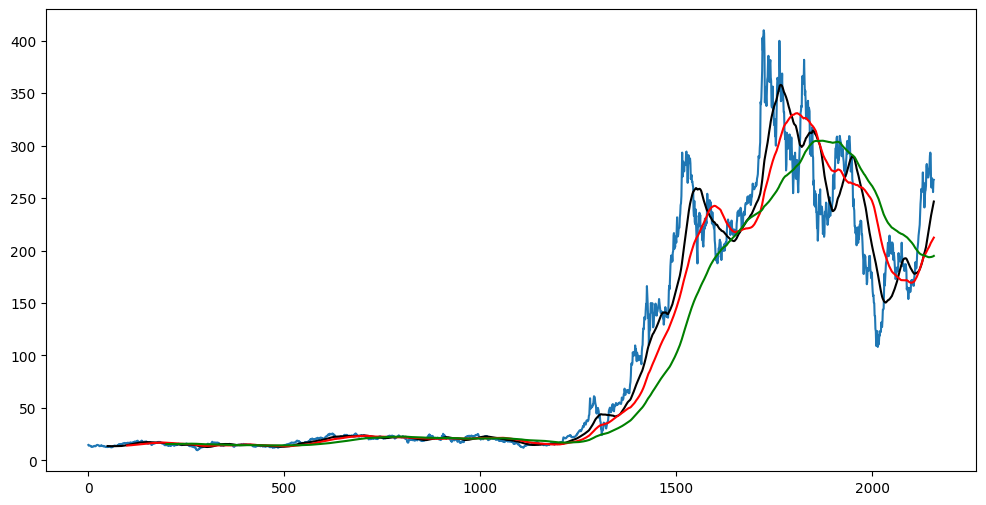

In [165]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma50, 'k')
plt.plot(ma100,'r')
plt.plot(ma200,'g')